In [37]:
import sys
sys.path.append('/home/amigos/ros/src/necst/lib')
if not sys.argv[1] == "-f":
    path = sys.argv[1]
    mode = "commandline"
else:
    # 手動で解析する場合はデータのあるpathを指定してください
    path = '/home/amigos/data/ps_edge_pointing/n20190909173347_12CO_2-1_crossedge_sun_pointing'
    mode = "notebook"

In [38]:
import n2df
import numpy
import matplotlib.pyplot as plt
import pickle
import os
from scipy.optimize import curve_fit

para_init1 = numpy.array([75, -1000, 0.0001])###
para_init2 = numpy.array([-75, 1000, 0.0001])###

In [39]:
def gaussian(x, a, mu, gamma):
    return a * numpy.exp(- gamma * (x - mu) **2) 

In [40]:
def calc_integdata(IF, data_list, mode_list, lam, bet, scan_list, integ_mi, integ_ma):

    data_list = data_list[IF-1]
    mode_list = mode_list[IF-1]
    lam = lam[IF-1]
    bet = bet[IF-1]
    scan_list = scan_list[IF-1]
    
    xmask = []
    ymask = []
    hotmask = []
    offmask = []
    for i in range(len(mode_list)):  
        if mode_list[i] == 'HOT':
            xmask.append(0)
            ymask.append(0)
            hotmask.append(1)
            offmask.append(0)
        elif mode_list[i] == 'OFF':
            xmask.append(0)
            ymask.append(0)
            hotmask.append(0)
            offmask.append(1)
        elif scan_list[i] == 1 and mode_list[i] == 'ON':
            xmask.append(1)
            ymask.append(0)
            hotmask.append(0)
            offmask.append(0)
        elif scan_list[i] == 2 and mode_list[i] == 'ON':
            xmask.append(0)
            ymask.append(1)
            hotmask.append(0)
            offmask.append(0)
    
# calc Ta*
    integlist = []
    for i in range(len(data_list)):
        l = data_list[i]
        integlist.append(numpy.sum(l[int(integ_mi):int(integ_ma)]))

    tmp = []
    HOT = []
    for i in range(len(hotmask)):
        if hotmask[i] == 1:
            HOT.append(integlist[i])
        else:
            pass
    for i in range(numpy.sum(hotmask) -1):
        t = []
        for j in range(int(len(hotmask)/4)):
            t.append(HOT[i])
        tmp.extend(t)
    tmp.append(HOT[numpy.sum(hotmask) -1])
    HOTlist = numpy.array(tmp)
    
    tmp = []
    OFF = []
    for i in range(len(offmask)):
        if offmask[i] == 1:
            OFF.append(integlist[i])
        else:
            pass
    for i in range(numpy.sum(offmask)):
        t = []
        for j in range(int(len(offmask)/4)):
            t.append(OFF[i])
        tmp.extend(t)
    tmp.append(OFF[numpy.sum(offmask) -1])
    OFFlist = numpy.array(tmp)
    
    ONlist = numpy.array(integlist)
    
    Taslist = (ONlist - OFFlist)/(HOTlist - OFFlist) * 300
    
    
# create data for plot
    xscan_Ta = []
    xscan_x = []
    xscan_y = []
    
    yscan_Ta = []
    yscan_x = []
    yscan_y = []

    for i in range(len(xmask)):
        if xmask[i] == 1:
            xscan_Ta.append(Taslist[i])
            xscan_x.append(lam[i])
            xscan_y.append(bet[i])
        else:
            pass

    for i in range(len(ymask)):
        if ymask[i] == 1:
            yscan_Ta.append(Taslist[i])
            yscan_x.append(lam[i])
            yscan_y.append(bet[i])
        else:
            pass

    return xscan_Ta, xscan_x, xscan_y, yscan_Ta, yscan_x, yscan_y

In [41]:
n = n2df.Read(os.path.join(path, "edge.ndf"))    
_n = n.read_all()
d = []
for i in range(25):
    _d = []
    for j in range(len(_n)):
        _d.append(_n[j][i])
    d.append(_d)

100%|██████████| 797/797 [00:00<00:00, 1025.56it/s]


In [42]:
time = d[0]
mode = d[21]
mode = list(map(lambda x:x.decode() ,mode))
subscan = d[22]
_lam = d[23]
_bet = d[24]

In [43]:
data_list = []
mode_list = []
scan_list = []
lam = []
bet = []

In [44]:
for h in range(20):
    d_ = d[h+1]
    d_list = []
    m_list = []
    s_list = []
    la_list = []
    be_list = []
    tmp = numpy.zeros(32768)
    for i in range(len(d_)):
        if subscan[i] == 1 and mode[i] == 'ON':
            #tmp += pickle.loads(d_[i])
            tmp += d_[i]
            if subscan[i+1] != subscan[i] or i == len(d_)-1 or _lam[i+1] != _lam[i]:
                d_list.append(tmp)
                m_list.append('ON')
                la_list.append(_lam[i])
                be_list.append(_bet[i])
                s_list.append(1)
                tmp = numpy.zeros(32768)
            else:
                pass
        elif subscan[i] == 2 and mode[i] == 'ON':
            #tmp += pickle.loads(d_[i])
            tmp += d_[i]
            if subscan[i+1] != subscan[i] or i == len(d_)-1 or _lam[i+1] != _lam[i]:
                d_list.append(tmp)
                m_list.append('ON')
                la_list.append(_lam[i])
                be_list.append(_bet[i])
                s_list.append(1)
                tmp = numpy.zeros(32768)
            else:
                pass
        elif subscan[i] == 3 and mode[i] == 'ON':
            #tmp += pickle.loads(d_[i])
            tmp += d_[i]
            if subscan[i+1] != subscan[i] or i == len(d_)-1 or _bet[i+1] != _bet[i]:
                d_list.append(tmp)
                m_list.append('ON')
                la_list.append(_lam[i])
                be_list.append(_bet[i])
                s_list.append(2)
                tmp = numpy.zeros(32768)
            else:
                pass
        elif subscan[i] == 4 and mode[i] == 'ON':
            #tmp += pickle.loads(d_[i])
            tmp += d_[i]
            if subscan[i+1] != subscan[i] or i == len(d_)-1 or _bet[i+1] != _bet[i]:
                d_list.append(tmp)
                m_list.append('ON')
                la_list.append(_lam[i])
                be_list.append(_bet[i])
                s_list.append(2)
                tmp = numpy.zeros(32768)
            else:
                pass
        elif mode[i] == 'OFF':
            #tmp += pickle.loads(d_[i])
            tmp += d_[i]
            if i == len(d_)-1:
                d_list.append(tmp)
                m_list.append('OFF')
                la_list.append(0)
                be_list.append(0)
                if subscan[i] == 1 or 2:
                    s_list.append(1)
                else:
                    s_list.append(2)
                tmp = numpy.zeros(32768)
            else: 
                if mode[i+1] != 'OFF':
                    d_list.append(tmp)
                    m_list.append('OFF')
                    la_list.append(0)
                    be_list.append(0)
                    if subscan[i] == '1' or '2':
                        s_list.append(1)
                    else:
                        s_list.append(2)
                    tmp = numpy.zeros(32768)
                else:
                    pass
        elif mode[i] == 'HOT':
            #tmp += pickle.loads(d_[i])
            tmp += d_[i]
            if i == len(d_)-1:
                d_list.append(tmp)
                m_list.append('HOT')
                la_list.append(0)
                be_list.append(0)
                if subscan[i] == 1 or 2:
                    s_list.append(1)
                else:
                    s_list.append(2)
                tmp = numpy.zeros(32768)
            else:
                if mode[i+1] != 'HOT':
                    d_list.append(tmp)
                    m_list.append('HOT')
                    la_list.append(0)
                    be_list.append(0)
                    if subscan[i] == 1 or 2:
                        s_list.append(1)
                    else:
                        s_list.append(2)
                    tmp = numpy.zeros(32768)
                else:
                    pass
                    
    data_list.append(d_list)
    mode_list.append(m_list)
    lam.append(la_list)
    bet.append(be_list)
    scan_list.append(s_list)

In [45]:
integ_mi = 5000
integ_ma = 10000

In [46]:
ret1 = calc_integdata(1, data_list, mode_list, lam, bet, scan_list, integ_mi, integ_ma)

In [47]:
xscan_Ta = ret1[0]
xscan_x = ret1[1]
xscan_y = ret1[2]
yscan_Ta = ret1[3]
yscan_x = ret1[4]
yscan_y = ret1[5]

In [48]:
fig = plt.figure()
    
ax = fig.add_subplot(1,1,1, aspect = 1)
    
im = ax.scatter(xscan_x, xscan_y, c = xscan_Ta, vmin = 0, vmax = 280, cmap="plasma")
ax.scatter(yscan_x, yscan_y, c = yscan_Ta, vmin = 0, vmax = 280)
    
fig.colorbar(im)

In [49]:
xscan_tmp = numpy.roll(xscan_Ta,1)
xscan_tmp[0] = 0
yscan_tmp = numpy.roll(yscan_Ta, 1)
yscan_tmp[0] = 0
    
xscan_dif = xscan_Ta - xscan_tmp
yscan_dif = yscan_Ta - yscan_tmp

[ERROR OCCURRED]
 Optimal parameters not found: Number of calls to function has reached maxfev = 800.


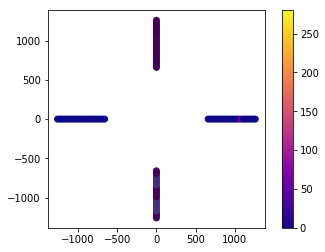

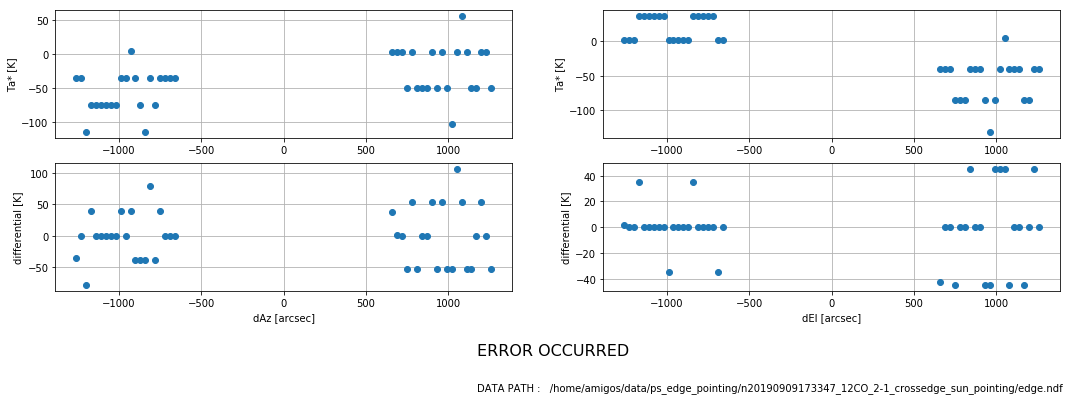

In [50]:
# Gaussian Fitting function add errorbar
try:
    x_az = numpy.linspace(xscan_x[0], xscan_x[-1], 2000)
    
# dAz fitting
    popt_az1, pcov_az1 = curve_fit(gaussian, xscan_x[:21], xscan_dif[:21], p0 = para_init1)
    error_az1 = numpy.sqrt(numpy.diag(pcov_az1))
#print("error",error_az1)
    popt_az2, pcov_az2 = curve_fit(gaussian, xscan_x[21:], xscan_dif[21:], p0 = para_init2)
    error_az2 = numpy.sqrt(numpy.diag(pcov_az2))
#print("error",error_az2)

    gaus_az1 = gaussian(x_az[:1000], popt_az1[0], popt_az1[1], popt_az1[2])
    gaus_az2 = gaussian(x_az[1000:], popt_az2[0], popt_az2[1], popt_az2[2])

    x_el = numpy.linspace(yscan_y[0], yscan_y[-1], 2000)
# El fitting
    popt_el1, pcov_el1 = curve_fit(gaussian, yscan_y[:21], yscan_dif[:21], p0 = para_init1)
    error_el1 = numpy.sqrt(numpy.diag(pcov_el1))
    popt_el2, pcov_el2 = curve_fit(gaussian, yscan_y[21:], yscan_dif[21:], p0 = para_init2)
    error_el2 = numpy.sqrt(numpy.diag(pcov_el2))

    gaus_el1 = gaussian(x_el[:1000], popt_el1[0], popt_el1[1], popt_el1[2])
    gaus_el2 = gaussian(x_el[1000:], popt_el2[0], popt_el2[1], popt_el2[2])


# dAz dEl
    dAz_mi = popt_az1[1]
    dAz_pu = popt_az2[1]
    dEl_mi = popt_el1[1]
    dEl_pu = popt_el2[1]
    dAz = (dAz_mi + dAz_pu)/2
    dEl = (dEl_mi + dEl_pu)/2


# Dif plot
    fig2 = plt.figure(figsize = (18, 8))

    axlist = [fig2.add_subplot(3,2,i+1) for i in range(6)]

    axlist[0].plot(xscan_x, xscan_Ta, "o")
    axlist[0].vlines(dAz_mi, 0, 300, linestyle = "dashed")
    axlist[0].vlines(dAz_pu, 0, 300, linestyle = "dashed")
    axlist[0].vlines(dAz, 0, 300)
    axlist[0].set_ylabel("Ta* [K]")

    axlist[1].plot(yscan_y, yscan_Ta, "o")
    axlist[1].vlines(dEl_mi, 0, 300, linestyle = "dashed")
    axlist[1].vlines(dEl_pu, 0, 300, linestyle = "dashed")
    axlist[1].vlines(dEl, 0, 300)
    axlist[1].set_ylabel("Ta* [K]")

    axlist[2].plot(xscan_x, xscan_dif, "o")
    axlist[2].plot(x_az[:1000], gaus_az1, color="k")
    axlist[2].plot(x_az[1000:], gaus_az2, color="k")
    axlist[2].set_xlabel("dAz [arcsec]")
    axlist[2].set_ylabel("differential [K]")

    axlist[3].plot(yscan_y, yscan_dif, "o")
    axlist[3].plot(x_el[:1000], gaus_el1, color="k")
    axlist[3].plot(x_el[1000:], gaus_el2, color="k")
    axlist[3].set_xlabel("dEl [arcsec]")
    axlist[3].set_ylabel("differential [K]")

    axlist[4].set_visible(False)
    axlist[5].set_visible(False)

    plt.axes([0.45,0.28, 0.25, 0.2])
    plt.axis("off")
    plt.text(0,0,"dAz = {}".format(round(dAz, 2)) + "              dEl = {}".format(round(dEl, 2)) + "   (arcsec)", fontsize = 16)
    plt.text(0, -0.3, "DATA PATH :   {}".format(file_name), fontsize=10)

    [a.grid() for a in axlist]

except Exception as e:
    print("\033[31m[ERROR OCCURRED]\033[0m\n", e)
    fig2 = plt.figure(figsize = (18, 8))

    axlist = [fig2.add_subplot(3,2,i+1) for i in range(6)]

    axlist[0].plot(xscan_x, xscan_Ta, "o")
    axlist[0].set_ylabel("Ta* [K]")

    axlist[1].plot(yscan_y, yscan_Ta, "o")
    axlist[1].set_ylabel("Ta* [K]")

    axlist[2].plot(xscan_x, xscan_dif, "o")
    axlist[2].set_xlabel("dAz [arcsec]")
    axlist[2].set_ylabel("differential [K]")

    axlist[3].plot(yscan_y, yscan_dif, "o")
    axlist[3].set_xlabel("dEl [arcsec]")
    axlist[3].set_ylabel("differential [K]")

    axlist[4].set_visible(False)
    axlist[5].set_visible(False)

    plt.axes([0.45,0.28, 0.25, 0.2])
    plt.axis("off")
    plt.text(0,0, "ERROR OCCURRED", fontsize = 16)
    plt.text(0, -0.3, "DATA PATH :   {}".format(file_name), fontsize=10)

            
    [a.grid() for a in axlist]
    
finally:
    plt.show()
